# Load synthetic

The load data are obtained from PJM.

'inst_load.csv' stores actual 5min load, 'very_short_load_frcst.csv' stores forecast 5min load, 'are_control_error.csv' stores the ACE every 15s.

All data are in MW.

Synthetic demand data from actual PJM datasets, the output is 'd_syn2.csv'.

Output = Load + ACE

Output contains 3600s of hour 10 and hour 18 in 3600 rows.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import os

In [2]:
dir_path = os.path.abspath('..')
data_path = '/data/'
load_inst = pd.read_csv(dir_path+data_path+"inst_load.csv")
load_frct = pd.read_csv(dir_path+data_path+"very_short_load_frcst.csv")
ace0 = pd.read_csv(dir_path+data_path+"area_control_error.csv")

In [3]:
ace = ace0[['datetime_beginning_utc', 'ace_mw']].copy()
ace.columns = ['utc_time', 'ace']
ace = ace[ace["utc_time"].str[:3] == '2/3'].copy()

ace["utc_time"] = pd.to_datetime(ace["utc_time"]).dt.strftime('%H:%M:%S')
# ace["utc_time"] = ace["utc_time"].dt.strftime('%H:%M:%S')

ace.sort_values(by="utc_time", inplace=True)
ace.reset_index(inplace=True, drop=True)

In [4]:
d_inst = load_inst[['datetime_beginning_utc', 'instantaneous_load']].copy()
d_frst0 = load_frct[['forecast_datetime_beginning_utc', 'forecast_load_mw']].copy()

d_inst.columns = ["utc_time", "d_inst"]
d_frst0.columns = ["utc_time", "d_frst"]

d_frst = d_frst0.groupby(by="utc_time", as_index=True, dropna=False).mean()
d_frst.reset_index(level=0, inplace=True)

d_data = pd.merge(d_inst, d_frst, on="utc_time", how="left")
d_data = d_data[d_data["utc_time"].str[:3] == '2/3'].copy()

d_data["utc_time"] = pd.to_datetime(d_data["utc_time"])
d_data["utc_time"] = d_data["utc_time"].dt.strftime('%H:%M:%S')

d_data.sort_values(by="utc_time", inplace=True)
d_data.reset_index(inplace=True, drop=True)

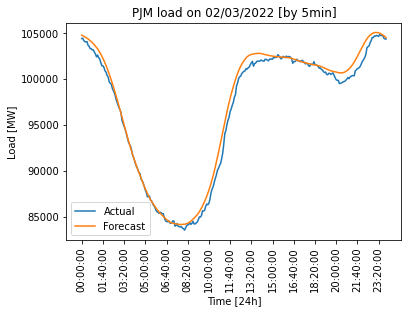

In [5]:
data_in = d_data
x = range(data_in.shape[0])
y1 = data_in["d_inst"]
y2 = data_in["d_frst"]

xt_loc = np.arange(0, data_in.shape[0], step=20)
xt_txt = data_in["utc_time"].iloc[xt_loc]

plt.plot(x, y1, label="Actual")
plt.plot(x, y2, label="Forecast")
plt.xticks(xt_loc, xt_txt, rotation=90)
plt.title("PJM load on 02/03/2022 [by 5min]")
plt.legend()
plt.xlabel("Time [24h]")
plt.ylabel("Load [MW]")
plt.show()

In [6]:
# Interpolate load, to (3600,)
# select a range and then interpolate it to 3600s

# 10H: 120: 132; 18H: 216: 228;

x10, x18 = 120, 216

lsyn = pd.DataFrame()
lsyn['time'] = list(range(0, 3610, int(3600/12)))  # the den should be the poitns within an hour
lsyn['h10'] = d_data['d_inst'].iloc[x10:x10+12+1].values
lsyn['h18'] = d_data['d_inst'].iloc[x18:x18+12+1].values

f10 = interp1d(lsyn['time'], lsyn['h10'])
f18 = interp1d(lsyn['time'], lsyn['h18'])

dsyn = pd.DataFrame()
dsyn['time'] = range(3600)
dsyn['h10'] = f10(np.array(range(3600)))
dsyn['h18'] = f18(np.array(range(3600)))

np.random.seed(2022)
k = 0.001
dsyn['ha10'] = dsyn['h10'] + np.random.normal(0, np.sqrt(k*dsyn['h10'].var()), size=3600)
dsyn['ha18'] = dsyn['h18'] + np.random.normal(0, np.sqrt(0.05*dsyn['h18'].var()), size=3600)

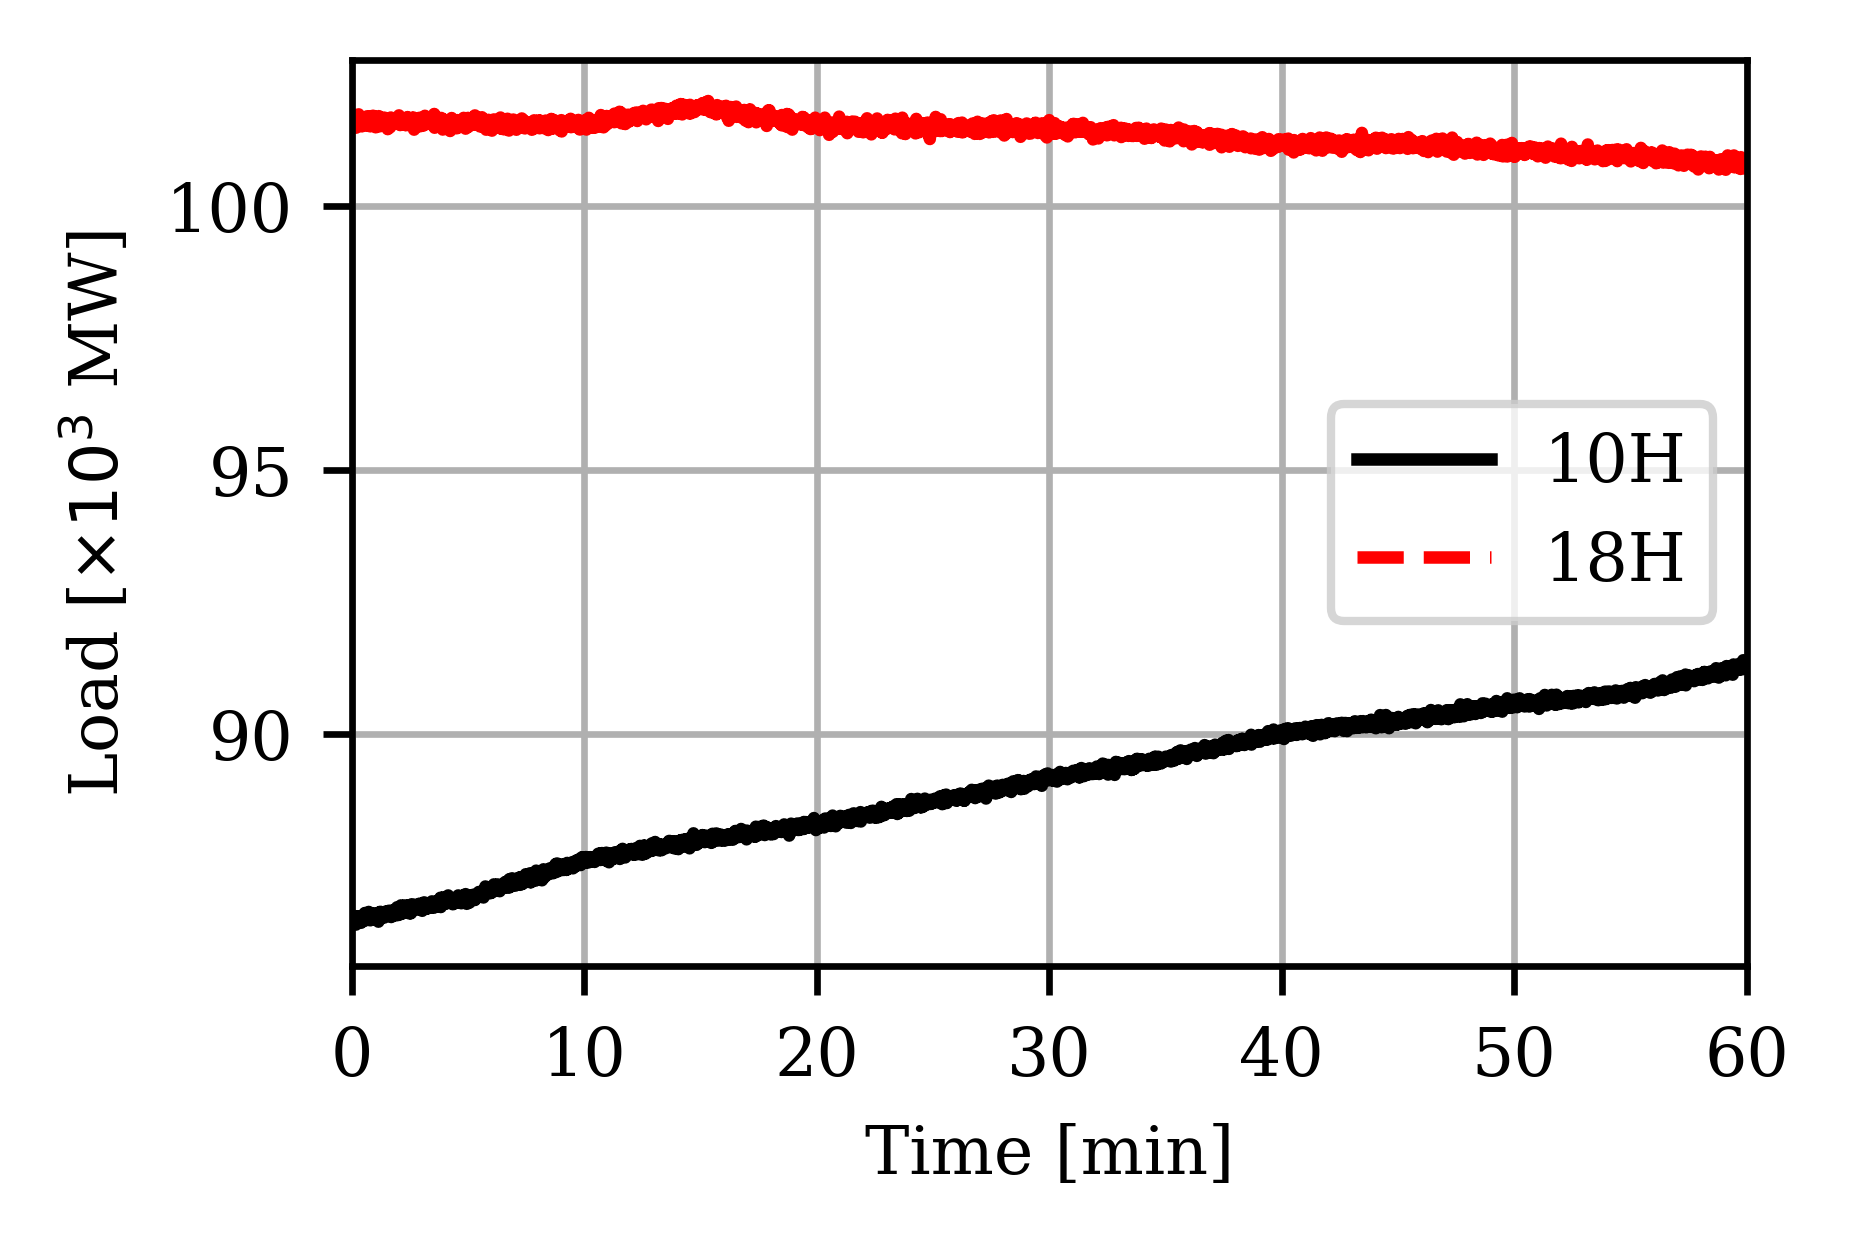

In [7]:
%matplotlib inline
with plt.style.context(['ieee']):
    fig, ax = plt.subplots(figsize=(3, 2))
    ax.plot(dsyn['time'], dsyn['ha10']/1000, label="10H")
    ax.plot(dsyn['time'], dsyn['ha18']/1000, label="18H")
    ax.set_ylabel(r"Load [$\times 10^3$ MW]")
    ax.set_xlabel("Time [min]")
    ax.set_xlim(0, 3600)
    ax.set_xticks(range(0, 3700, 600), range(0, 61, 10))
    ax.legend()
    ax.grid()

In [8]:
fig.savefig('fig_loadcurve.eps', format='eps', bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [9]:
dsyn.to_csv(dir_path+'/case/dsyn.csv', index=False)